In [6]:
import numpy as np
import copy
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [63]:
def softmax(x):
  max_x = np.max(x)
  exp_x = np.exp(x - max_x)
  return exp_x / np.sum(exp_x)

def sigmoid(z):
  return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
  return sigmoid(z)*(1-sigmoid(z))

def act_func(u: float) -> float:
  return max(0, u)
#   return sigmoid(u)

def act_func_prime(z_vec):
  return_vec = np.zeros(len(z_vec))
  return_vec[z_vec >= 0] = 1
  return return_vec
#   return_vec = np.zeros(len(z_vec))
#   for i in range(0, len(return_vec)):
#     return_vec[i] = sigmoid_prime(z_vec[i])
#   return return_vec

def loss_func(res_vec, target_vec):
  return np.sum(np.power(res_vec - target_vec, 2)) / 2

def loss_derivative(y_vec, t_vec):
  return y_vec - t_vec

class perceptron:
  # input: size(int), output: 1
  def __init__(self, size: int):
    self.w_vec = np.random.randn(size)
    self.bias = 0

  def calc(self, x_vec):
    u = np.sum(np.multiply(x_vec, self.w_vec)) + self.bias
    return (u, act_func(u))

  def train(self, x_vec, d: float, kappa: float):
    # d: target value, kappa: learning coeff
    self.w_vec -= kappa * (self.calc(x_vec) - d) * x_vec
    print('trained')
  
  def set(self, w_vec, bias):
    self.w_vec = w_vec
    self.bias = bias

class layer:
  def __init__(self, prev_node_num: int, percep_num: int):
    self.perceptrons = []
    for i in range(0, percep_num):
      self.perceptrons.append(perceptron(prev_node_num))
    self.z_vec = np.zeros(percep_num) # before act_func
    self.y_vec = np.zeros(percep_num) # after act_func
  
  def forward(self, prev_y_vec):
    for i in range(0, len(self.perceptrons)):
      (this_z, this_y) = self.perceptrons[i].calc(prev_y_vec)
      self.z_vec[i] = this_z
      self.y_vec[i] = this_y
  
class input_layer:
  def __init__(self, size):
    self.y_vec = np.zeros(size)
  
  def set_y(self, input_vec):
    self.y_vec = input_vec

def train_network(iteration: int):
  cost_avgs = []
  for i_iteration in range(0, iteration):
    if i_iteration % 10 == 0:
      print('iteration ' + str(i_iteration))
    cost_avg = 0
    y_vec_arr = []
    delta = []
    for (cur_train_image, cur_train_label) in zip(train_images, train_labels):
      #(cur_train_image, cur_train_label) = (train_images[0], train_labels[0])
      y_vec_arr.append([])
      layers[0].set_y(cur_train_image.flatten())
      y_vec_arr[-1].append(layers[0].y_vec)
      for i in range(1, len(layers)):
        layers[i].forward(layers[i-1].y_vec)
        y_vec_arr[-1].append(layers[i].y_vec)
        
      train_vector = np.zeros(10)
      train_vector[cur_train_label] = 1
      delta.append([]) # delta[i][j][k]: ith train img, jth layer, kth perceptron(?)
      for i in range(0, len(layers)):
        delta[-1].append([])
      delta[-1][-1] = loss_derivative(layers[-1].y_vec, train_vector) * act_func_prime(layers[-1].z_vec)
      cost_avg += loss_func(layers[-1].y_vec, train_vector)

      for i in reversed(range(1, len(layers) - 1)):
        # print('layer ' + str(i))
        # print('perceptrons ' + str(len(layers[i+1].perceptrons)))
        # print('w ' + str(len(layers[i+1].perceptrons[0].w_vec)))
        # print('delta ' + str(len(delta[-1][i+1])))
        # print('z_vec ' + str(len(layers[i].z_vec)))
        w_mat = np.zeros((len(layers[i+1].perceptrons), len(layers[i+1].perceptrons[0].w_vec)))
        for i_p in range(0, len(layers[i+1].perceptrons)):
          # w_delta[i_p] = np.dot(layers[i+1].perceptrons[i_p].w_vec, delta[i+1])
          w_mat[i_p] = layers[i+1].perceptrons[i_p].w_vec
        w_delta = np.dot(np.transpose(w_mat), delta[-1][i+1])
        delta[-1][i] = w_delta * act_func_prime(layers[i].z_vec)

    # print('delta ' + str(delta[0][-1]))

    for i in range(1, len(layers)):
      w_mat = np.zeros((len(layers[i].perceptrons), len(layers[i].perceptrons[0].w_vec)))
      bias_vec = np.zeros(len(layers[i].perceptrons))
      for i_p in range(0, len(layers[i].perceptrons)):
        w_mat[i_p] = layers[i].perceptrons[i_p].w_vec
        bias_vec[i_p] = layers[i].perceptrons[i_p].bias
      delta_sum = np.zeros(len(delta[0][i]))
      delta_a_sum = np.zeros(w_mat.shape)
      for i_x in range(0, len(train_images)):
        delta_sum += delta[i_x][i]
        # print(w_mat.shape)
        # print(delta[i_x][i].shape)
        # print(y_vec_arr[i_x][i-1].shape)
        # print(np.outer(delta[i_x][i], y_vec_arr[i_x][i-1]))
        delta_a_sum += np.outer(delta[i_x][i], y_vec_arr[i_x][i-1])
      w_new = w_mat - ((kappa / len(train_images)) * delta_a_sum) # prev_perceptron * this_perceptronの行列
      # bias_new = bias_vec - kappa / len(train_images) * np.sum(delta, axis=0)
      bias_new = bias_vec - kappa / len(train_images) * delta_sum
      # print('w before ' + str(w_mat))
      # print('delta sum ' + str(delta_a_sum))
      # print('w new ' + str(w_new))
      # print(bias_new)
      for i_p in range(0, len(layers[i].perceptrons)):
        layers[i].perceptrons[i_p].set(w_new[i_p], bias_new[i_p])
    cost_avg /= len(train_images)
    cost_avgs.append(cost_avg)
  x_axis = np.arange(iteration)
  plt.plot(x_axis, cost_avgs)
  plt.show()



def train_network_batch(batch_size: int, batch_time: int):
  cost_avgs = []
  
  for i_batch in range(0, batch_time):
    batched_train_images = train_images[i_batch * batch_size : (i_batch + 1) * batch_size]
    batched_train_labels = train_labels[i_batch * batch_size : (i_batch + 1) * batch_size]
    print('batch num ' + str(i_batch))
    cost_avg = 0
    y_vec_arr = []
    delta = []
    for (cur_train_image, cur_train_label) in zip(batched_train_images, batched_train_labels):
      #(cur_train_image, cur_train_label) = (train_images[0], train_labels[0])
      y_vec_arr.append([])
      layers[0].set_y(cur_train_image.flatten())
      y_vec_arr[-1].append(layers[0].y_vec)
      for i in range(1, len(layers)):
        layers[i].forward(layers[i-1].y_vec)
        y_vec_arr[-1].append(layers[i].y_vec)
        
      train_vector = np.zeros(10)
      train_vector[cur_train_label] = 1
      delta.append([]) # delta[i][j][k]: ith train img, jth layer, kth perceptron(?)
      for i in range(0, len(layers)):
        delta[-1].append([])
      delta[-1][-1] = loss_derivative(layers[-1].y_vec, train_vector) * act_func_prime(layers[-1].z_vec)
      cost_avg += loss_func(layers[-1].y_vec, train_vector)

      for i in reversed(range(1, len(layers) - 1)):
        # print('layer ' + str(i))
        # print('perceptrons ' + str(len(layers[i+1].perceptrons)))
        # print('w ' + str(len(layers[i+1].perceptrons[0].w_vec)))
        # print('delta ' + str(len(delta[-1][i+1])))
        # print('z_vec ' + str(len(layers[i].z_vec)))
        w_mat = np.zeros((len(layers[i+1].perceptrons), len(layers[i+1].perceptrons[0].w_vec)))
        for i_p in range(0, len(layers[i+1].perceptrons)):
          # w_delta[i_p] = np.dot(layers[i+1].perceptrons[i_p].w_vec, delta[i+1])
          w_mat[i_p] = layers[i+1].perceptrons[i_p].w_vec
        w_delta = np.dot(np.transpose(w_mat), delta[-1][i+1])
        delta[-1][i] = w_delta * act_func_prime(layers[i].z_vec)

    # print('delta ' + str(delta[0][-1]))

    for i in range(1, len(layers)):
      w_mat = np.zeros((len(layers[i].perceptrons), len(layers[i].perceptrons[0].w_vec)))
      bias_vec = np.zeros(len(layers[i].perceptrons))
      for i_p in range(0, len(layers[i].perceptrons)):
        w_mat[i_p] = layers[i].perceptrons[i_p].w_vec
        bias_vec[i_p] = layers[i].perceptrons[i_p].bias
      delta_sum = np.zeros(len(delta[0][i]))
      delta_a_sum = np.zeros(w_mat.shape)
      for i_x in range(0, len(batched_train_images)):
        delta_sum += delta[i_x][i]
        # print(w_mat.shape)
        # print(delta[i_x][i].shape)
        # print(y_vec_arr[i_x][i-1].shape)
        # print(np.outer(delta[i_x][i], y_vec_arr[i_x][i-1]))
        delta_a_sum += np.outer(delta[i_x][i], y_vec_arr[i_x][i-1])
      w_new = w_mat - ((kappa / len(batched_train_images)) * delta_a_sum) # prev_perceptron * this_perceptronの行列
      # bias_new = bias_vec - kappa / len(train_images) * np.sum(delta, axis=0)
      bias_new = bias_vec - kappa / len(batched_train_images) * delta_sum
      # print('w before ' + str(w_mat))
      # print('delta sum ' + str(delta_a_sum))
      # print('w new ' + str(w_new))
      # print(bias_new)
      for i_p in range(0, len(layers[i].perceptrons)):
        layers[i].perceptrons[i_p].set(w_new[i_p], bias_new[i_p])
    cost_avg /= len(batched_train_images)
    cost_avgs.append(cost_avg)
  x_axis = np.arange(batch_time)
  plt.plot(x_axis, cost_avgs)
  plt.show()

In [61]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
test_images = np.array(np.float32(test_images)) / 255
train_images = np.array(np.float32(train_images)) / 255
train_images = train_images
train_labels = train_labels
print('mnist loaded')

network_size = [len(test_images[0].flatten()), 64, 10]
kappa = 0.001

layers = []
layers.append(input_layer(len(test_images[0].flatten())))
for i in range(1, len(network_size)):
  layers.append(layer(network_size[i-1], network_size[i]))

# train_images = train_images[0:10]
# train_labels = train_labels[0:10]

mnist loaded


batch num 0
batch num 1
batch num 2
batch num 3
batch num 4
batch num 5
batch num 6
batch num 7
batch num 8
batch num 9
batch num 10
batch num 11
batch num 12
batch num 13
batch num 14
batch num 15
batch num 16
batch num 17
batch num 18
batch num 19
batch num 20
batch num 21
batch num 22
batch num 23
batch num 24
batch num 25
batch num 26
batch num 27
batch num 28
batch num 29
batch num 30
batch num 31
batch num 32
batch num 33
batch num 34
batch num 35
batch num 36
batch num 37
batch num 38
batch num 39
batch num 40
batch num 41
batch num 42
batch num 43
batch num 44
batch num 45
batch num 46
batch num 47
batch num 48
batch num 49
batch num 50
batch num 51
batch num 52
batch num 53
batch num 54
batch num 55
batch num 56
batch num 57
batch num 58
batch num 59
batch num 60
batch num 61
batch num 62
batch num 63
batch num 64
batch num 65
batch num 66
batch num 67
batch num 68
batch num 69
batch num 70
batch num 71
batch num 72
batch num 73
batch num 74
batch num 75
batch num 76
batch num

batch num 597
batch num 598
batch num 599


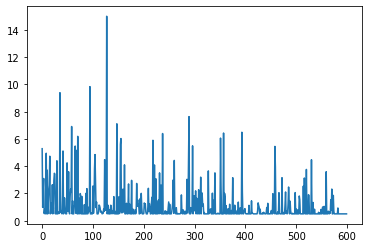

training done
forwarding
forwarding
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
5


In [66]:
train_network_batch(100, 600)
print('training done')
layers[0].set_y(train_images[0].flatten())
for i in range(1, len(layers)):
  print('forwarding')
  # print(layers[i].y_vec)
  layers[i].forward(layers[i-1].y_vec)
  # print(layers[i].y_vec)
print(softmax(layers[-1].y_vec))
print(train_labels[0])

In [29]:
layers[0].set_y(train_images[2].flatten())
for i in range(1, len(layers)):
  print('forwarding')
  # print(layers[i].y_vec)
  layers[i].forward(layers[i-1].y_vec)
  # print(layers[i].y_vec)
print(softmax(layers[-1].y_vec))
print(train_labels[2])

forwarding
forwarding
forwarding
[0.10267665 0.10386278 0.09653331 0.10075091 0.10079535 0.0959269
 0.10076079 0.09985069 0.09804901 0.10079361]
4


In [13]:
10 % 5

0